In [1]:
from tensoraerospace.agent.pid import PIDController
import numpy as np
from tqdm import tqdm

from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step

In [2]:
dt = 0.01  # Дискретизация
tp = generate_time_period(tn=20, dt=dt) # Временной периуд
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp) # Количество временных шагов
reference_signals = np.reshape(unit_step(degree=5, tp=tp, time_step=10, output_rad=True), [1, -1]) # Заданный сигнал

In [3]:
from tensorboardX import SummaryWriter
import gymnasium as gym 
from tensoraerospace.benchmark.function import overshoot, settling_time, static_error

In [4]:
writer = SummaryWriter()

In [29]:
# pid_config = {'ki': -0.950533422720504, 'kp': -7.38371410120775, 'kd': 3.0546935621436617}
# pid_config = {'ki': -0.950533422720504, 'kp': -7.38371410120775, 'kd': 3.0546935621436617}
pid_config = {'ki': -0.9521120376180967, 'kp': -8.374525879223533, 'kd': 7.281084470573987}

# pid_config = {'ki': -9.41904814284741, 'kp': -2.419889382764948, 'kd': -1.0979980771661264}



In [30]:
hist = []
dt = 0.01  # Дискретизация
tp = generate_time_period(tn=40, dt=dt) # Временной периуд
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp) # Количество временных шагов
reference_signals = np.reshape(unit_step(degree=5, tp=tp, time_step=10, output_rad=True), [1, -1]) # Заданный сигнал
env = gym.make('LinearLongitudinalF16-v0',
               number_time_steps=number_time_steps, 
               initial_state=[[0],[0],[0],[0]],
               reference_signal = reference_signals,
              tracking_states=["alpha"])
env.reset()
pid = PIDController(kp=pid_config["kp"], ki=pid_config["ki"], kd=pid_config["kd"], dt=dt)
xt = np.array([[np.deg2rad(0)], [0]])
for step in range(number_time_steps - 2):
    setpoint = reference_signals[0, step]
    hist.append(xt[0, 0])
    ut  = pid.update(setpoint, xt[0, 0])
    xt, reward, terminated, truncated, info = env.step(np.array([ut.item()]))


/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:246: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(


In [31]:
np.abs(static_error(reference_signals, hist))

0.0211635186702495

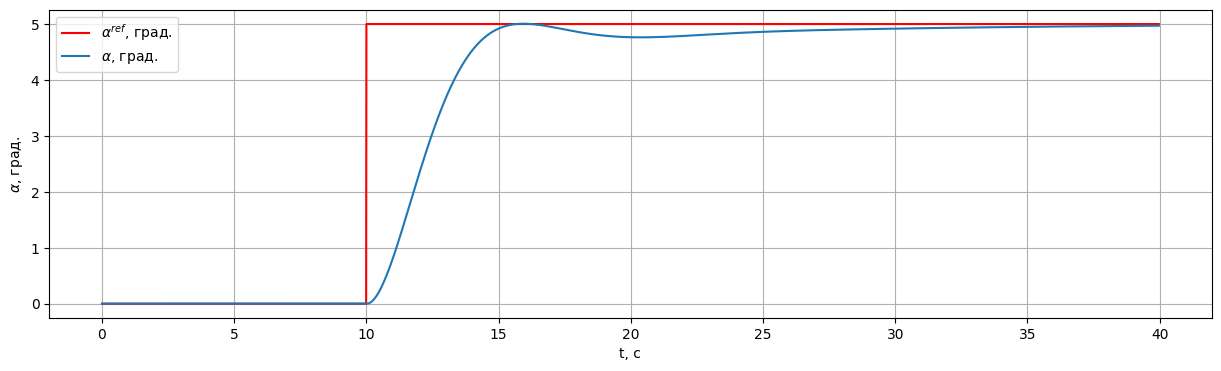

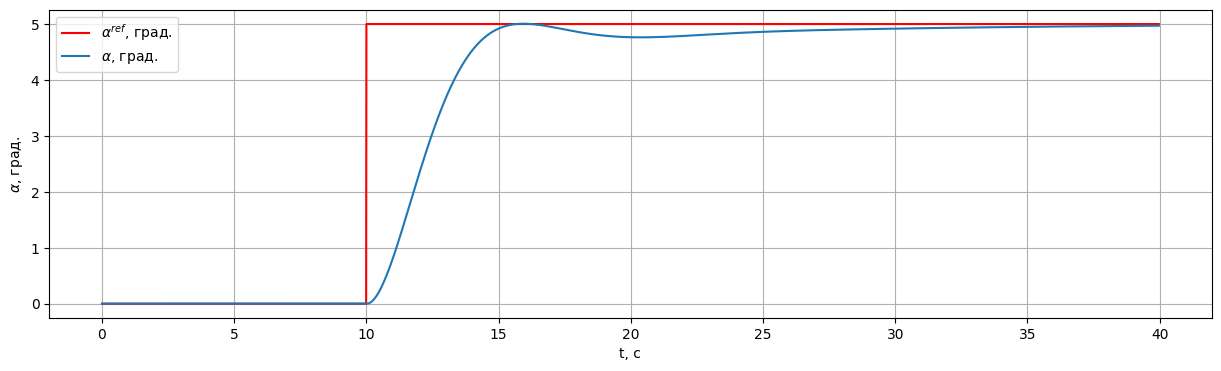

In [32]:
env.unwrapped.model.plot_transient_process('alpha', tps, reference_signals[0], to_deg=True, figsize=(15,4))

In [33]:
system_signal_orig = env.unwrapped.model.get_state('alpha', to_deg=True)[:4000]
control_signal_orig = np.rad2deg(reference_signals[0])[:4000]

In [34]:
from tensoraerospace.benchmark import ControlBenchmark
static_error(control_signal_orig, system_signal_orig)

0.03706961499610539

In [35]:
overshoot(control_signal_orig, system_signal_orig)

0.11371367045088121

In [36]:
settling_time(control_signal_orig, system_signal_orig)*0.01

14.450000000000001